In [1]:
import keras
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, Dropout, MaxPooling2D
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import keras.metrics as metrics
import numpy as np
from PIL import Image
import glob
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#get image file names
file_glob = glob.glob('Fixed_Images/*.jpg')

In [3]:
data = pd.read_csv('dataset.csv') 
df = data.copy()

In [4]:
df.drop_duplicates(['GSTkts', 'WDIR', 'WSPDkts', 'time_stamp'], keep='first', inplace = True)

In [5]:
df.sort_values(by = 'time_stamp', inplace = True)

In [6]:
df = df.reset_index(drop = True)

In [171]:
#df.head()

In [8]:
df.time_stamp = pd.to_datetime(df.time_stamp)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8953 entries, 0 to 8952
Data columns (total 5 columns):
GSTkts        8953 non-null float64
WDIR          8953 non-null object
WSPDkts       8953 non-null float64
WVHTft        1474 non-null float64
time_stamp    8953 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 349.8+ KB


In [10]:
#return datetime object at time with wvht
def get_time_stamp(name):
    p = 0
    img_date = name.split('_')[2:4]
    img_edt = int(name.split('_')[-1:][0].split('.')[0])
    img_edt = str(img_edt).zfill(4)
    img_edt = list(img_edt)
    img_edt[-2:] = ['4', '0']
    img_edt = ''.join(img_edt)
    img_edt = str(img_edt)
    date = '{}-{}-{} {}' .format('2020', img_date[0], img_date[1], img_edt)
    date = pd.to_datetime(date)
    #date = date - datetime.timedelta(minutes=30)
    return date

In [11]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [12]:
model = Sequential()
model.add(TimeDistributed(vgg, input_shape=(6, 224, 224, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))
model.add(TimeDistributed(MaxPooling2D()))
model.add(TimeDistributed(Flatten()))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 6, 7, 7, 512)      14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 3, 3, 512)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 6, 1, 1, 512)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 6, 512)            0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [39]:
#returns tensor list from 6 image slices and target
num_targets = 500
targets = []
tensor_stack = []
def to_tensor(img_path):
    img_time = get_time_stamp(img_path)
    target = df.query('time_stamp == @img_time')['WVHTft']
    if len(target) == 0:
        failed_paths_new.append(img_path)
    else:
        targets.append(target.values[0])
    img = image.load_img(img_path, target_size=(260, 1344))
    img_arr = np.array(img)
    list_of_tensors = []
    for i in range(0,6):
        slice_show = i
        slice_size = 1344/6
        img_slice = img_arr[:224, slice_size * slice_show:slice_size * (slice_show + 1), :]
        list_of_tensors.append(np.expand_dims(img_slice, axis=0).astype('float32')/255)
    return np.vstack(list_of_tensors) 

for f in file_glob[:num_targets]:
    tensors = to_tensor(f)
    tensor_stack.append(tensors)

In [40]:
predictions = []
for t in tensor_stack:
    t = np.array(t).reshape(1, 6, 224, 224, 3)
    preds = model.predict(t)
    predictions.append(preds)

In [183]:
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)

In [206]:
#build model
lstm = Sequential()
lstm.add(LSTM(1024, return_sequences = True, input_shape = (6, 512)))
lstm.add(LSTM(1024))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer='adam', metrics = [metrics.mean_squared_error])
lstm.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 6, 1024)           6295552   
_________________________________________________________________
lstm_28 (LSTM)               (None, 1024)              8392704   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1025      
Total params: 14,689,281
Trainable params: 14,689,281
Non-trainable params: 0
_________________________________________________________________


In [207]:
#check for inf or nan
np.isfinite(x).all()

True

In [208]:
#x = np.array(predictions).reshape(num_targets, 6, 512)

In [209]:
test_size = 55#len(x)
hist = lstm.fit(x[:test_size], targets[:test_size], epochs = 125)

Epoch 1/125
55/55 [==============================] - 4s 68ms/step - loss: 47.5814 - mean_squared_error: 47.5814
Epoch 2/125
55/55 [==============================] - 1s 20ms/step - loss: 67.8623 - mean_squared_error: 67.8623
Epoch 3/125
55/55 [==============================] - 1s 20ms/step - loss: 29.4702 - mean_squared_error: 29.4701
Epoch 4/125
55/55 [==============================] - 1s 19ms/step - loss: 17.4253 - mean_squared_error: 17.4253
Epoch 5/125
55/55 [==============================] - 1s 19ms/step - loss: 12.7499 - mean_squared_error: 12.7499
Epoch 6/125
55/55 [==============================] - 1s 19ms/step - loss: 11.8790 - mean_squared_error: 11.8790
Epoch 7/125
55/55 [==============================] - 1s 19ms/step - loss: 11.0392 - mean_squared_error: 11.0392
Epoch 8/125
55/55 [==============================] - 1s 19ms/step - loss: 10.8005 - mean_squared_error: 10.8005
Epoch 9/125
55/55 [==============================] - 1s 19ms/step - loss: 10.9262 - mean_squared_error: 

55/55 [==============================] - 1s 21ms/step - loss: 0.5875 - mean_squared_error: 0.5875
Epoch 75/125
55/55 [==============================] - 1s 23ms/step - loss: 0.4042 - mean_squared_error: 0.4042
Epoch 76/125
55/55 [==============================] - 1s 24ms/step - loss: 0.3699 - mean_squared_error: 0.3699
Epoch 77/125
55/55 [==============================] - 1s 23ms/step - loss: 0.4272 - mean_squared_error: 0.4272
Epoch 78/125
55/55 [==============================] - 1s 21ms/step - loss: 0.3120 - mean_squared_error: 0.3120
Epoch 79/125
55/55 [==============================] - 1s 21ms/step - loss: 0.2913 - mean_squared_error: 0.2913
Epoch 80/125
55/55 [==============================] - 1s 21ms/step - loss: 0.3227 - mean_squared_error: 0.3227
Epoch 81/125
55/55 [==============================] - 1s 24ms/step - loss: 0.3082 - mean_squared_error: 0.3082
Epoch 82/125
55/55 [==============================] - 2s 28ms/step - loss: 0.2936 - mean_squared_error: 0.2936
Epoch 83/125
5

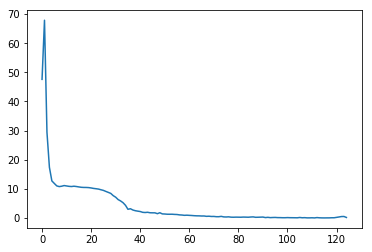

In [210]:
plt.plot(hist.history['loss']);

In [217]:
num = 12
p = x[num]
p = p.reshape(1, 6, 512)
targets[num]

9.2

In [218]:
lstm.predict(p)

array([[9.437326]], dtype=float32)